# Example - Kickstarter

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Target" data-toc-modified-id="Target-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#Feature-Importance-migration" data-toc-modified-id="Feature-Importance-migration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance migration</a></span></li><li><span><a href="#Reverse-Learning-Curve" data-toc-modified-id="Reverse-Learning-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reverse Learning Curve</a></span></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Feature-Impact" data-toc-modified-id="Feature-Impact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Impact</a></span></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-design-for-the-RF" data-toc-modified-id="Other-optimization-design-for-the-RF-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other optimization design for the RF</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/kickstarter/"
PREFIX = "kickstarter"

In [5]:
data = pd.read_csv(DATASETS_PATH + "ks-projects-201801.csv", engine="python")

In [6]:
#data = data.sample(frac=0.20)

In [7]:
data.shape

(378661, 15)

In [8]:
print(data["launched"].min())
print(data["launched"].max())

print(data["deadline"].min())
print(data["deadline"].max())

data["launched"] = pd.to_datetime(data["launched"])
data["deadline"] = pd.to_datetime(data["deadline"])
data["Year"] = data["launched"].apply(lambda x: int(x.year))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["difference_launched_deadline"] = (data["deadline"] - data["launched"]).dt.days

1970-01-01 01:00:00
2018-01-02 15:02:31
2009-05-03
2018-03-03


In [9]:
data.nunique()

ID                              378661
name                            375764
category                           159
main_category                       15
currency                            14
deadline                          3164
goal                              8353
launched                        378089
pledged                          62130
state                                6
backers                           3963
country                             23
usd pledged                      95455
usd_pledged_real                106065
usd_goal_real                    50339
Year                                11
Year-Month                         107
difference_launched_deadline        99
dtype: int64

In [10]:
data.dtypes

ID                                       int64
name                                    object
category                                object
main_category                           object
currency                                object
deadline                        datetime64[ns]
goal                                   float64
launched                        datetime64[ns]
pledged                                float64
state                                   object
backers                                  int64
country                                 object
usd pledged                            float64
usd_pledged_real                       float64
usd_goal_real                          float64
Year                                     int64
Year-Month                              object
difference_launched_deadline             int64
dtype: object

## Modeling

### Target

In [11]:
data["state"].unique()
data["target"] = (data["state"] == "successful").astype(int)
data["target"].mean()

0.3537623362321443

### Data

In [12]:
TIME_COLUMN = "Year"
TARGET = "target"

In [13]:
data["launched"] = pd.to_datetime(data["launched"])
data["deadline"] = pd.to_datetime(data["deadline"])
data["Year"] = data["launched"].apply(lambda x: int(x.year))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))
data["difference_launched_deadline"] = (data["deadline"] - data["launched"]).dt.days

In [14]:
columns_to_label_encode = ["country", 
                           "currency",
                           "category",
                           "main_category"]

In [15]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

country
currency


/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


category
main_category


In [16]:
data["goal"] = data["goal"].astype(int)
features = ["goal", "difference_launched_deadline"] + columns_to_label_encode
data["Year"].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
1970        7
Name: Year, dtype: int64

In [17]:
numerical_features = [f for f in features if f not in columns_to_label_encode]

In [18]:
data["Year"].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
1970        7
Name: Year, dtype: int64

In [19]:
data = data[~data["Year"].isin([1970, 2018, 2009])]

In [20]:
data["Year"] = data["Year"].apply(lambda x: 2011 if x==2010 else x)

In [21]:
training_start_year = 2011
training_end_year = 2013
holdout_end_year = 2017

In [22]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [23]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [24]:
train.shape

(98217, 19)

In [25]:
test.shape

(24555, 19)

In [26]:
out_of_time.shape

(254429, 19)

In [27]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Checking the support in the different environments

In [28]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2011    0.166667
2012    0.500000
2013    1.000000
Name: country, dtype: float64
Year
2011    0.2
2012    0.4
2013    1.0
Name: currency, dtype: float64
Year
2011    0.618421
2012    0.710526
2013    0.973684
Name: category, dtype: float64
Year
2011    1.0
2012    1.0
2013    1.0
Name: main_category, dtype: float64


0.714108187134503

In [29]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year
2011    0.333333
2012    0.666667
2013    0.777778
Name: goal_quant, dtype: float64
Year
2011    1.0
2012    0.7
2013    0.8
Name: difference_launched_deadline_quant, dtype: float64


/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/time_robust_forest/functions.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels=[i for i in range(1, n_q + 1)],


0.712962962962963

### Benchmark

In [30]:
from pycaret.classification import *

In [31]:
TARGET

'target'

In [32]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6418,0.6941,0.6642,0.5800,0.6193,0.2839,0.2863
1,0.6396,0.6948,0.6610,0.5779,0.6167,0.2796,0.2818
2,0.6436,0.6983,0.6584,0.5830,0.6184,0.2864,0.2883
3,0.6458,0.7023,0.6614,0.5852,0.6210,0.2909,0.2928
4,0.6425,0.6992,0.6525,0.5825,0.6155,0.2834,0.2850
Mean,0.6427,0.6977,0.6595,0.5817,0.6182,0.2849,0.2868
SD,0.0020,0.0030,0.0040,0.0025,0.0019,0.0037,0.0037


In [33]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [34]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [35]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_sklearn"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_sklearn"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_sklearn"]))

0.7080926270369595
0.6984534759476457
0.6627537642942651


In [36]:
params_grid = {"n_estimators": [120], 
              "max_depth": [8, 12],
              "min_impurity_decrease": [1e-3, 1e-5, 0],
              "min_sample_periods": [1, 5, 10],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")
# params_grid = {"n_estimators": [5], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0.001],
#               "min_sample_periods": [5]}

['max', 'avg']

In [37]:
params_grid

{'n_estimators': [120],
 'max_depth': [8, 12],
 'min_impurity_decrease': [0.001, 1e-05, 0],
 'min_sample_periods': [1, 5, 10],
 'period_criterion': ['max', 'avg']}

In [38]:
params_grid_benchmark

{'n_estimators': [120],
 'max_depth': [8, 12],
 'min_impurity_decrease': [0.001, 1e-05, 0],
 'min_sample_periods': [1, 5, 10]}

In [39]:
DUMMY_TIME_COLUMN = "dummy_time_column"
train[DUMMY_TIME_COLUMN] = 1

In [40]:
# model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
#                                         multi=True)

# benchmark_opt_param = env_wise_hyper_opt(train[features + [DUMMY_TIME_COLUMN]], train[TARGET], 
#                                          model, 
#                                          DUMMY_TIME_COLUMN, 
#                                          params_grid_benchmark, 
#                                          cv=5,
#                                          score=roc_auc_score)

benchmark_opt_param = {'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 120}

In [41]:
benchmark_opt_param

{'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 120}

In [42]:
benchmark_model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)

In [43]:
benchmark_model.fit(train[features + [DUMMY_TIME_COLUMN]], train[TARGET].values)

In [44]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [45]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.7364446098043356
0.7053232523067752
0.6476089215303401


In [ ]:
results = reverse_learning_curve(train, 
                                 out_of_time, 
                                 benchmark_model, 
                                 features, 
                                 TARGET,
                                 TIME_COLUMN, 
                                 roc_auc_score, 
                                 n_rounds=5,
                                 dummy_time_column=DUMMY_TIME_COLUMN)

In [ ]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

In [ ]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, 
                                                                                             features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

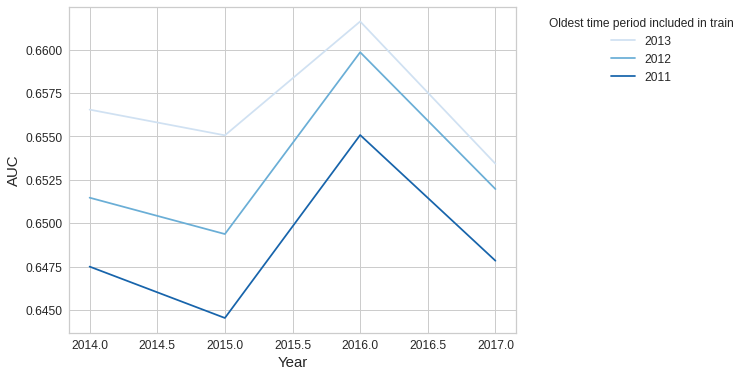

In [150]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
results

## Challenger model

In [ ]:
train.reset_index(drop=True, inplace=True)

In [ ]:
train[features + [TIME_COLUMN]]

In [ ]:
train["Year"].value_counts()

In [ ]:
model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True)

challenger_opt_param = env_wise_hyper_opt(train[features + [TIME_COLUMN]], 
                                          train[TARGET], 
                                          model, 
                                          TIME_COLUMN,
                                          params_grid,
                                          cv=5,
                                          score=roc_auc_score)

challenger_opt_param = {'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 120,
 'period_criterion': 'max'}

In [122]:
challenger_opt_param

{'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 120,
 'period_criterion': 'max'}

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [123]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.7174605236722856
0.7015653647184394
0.661753121209149


## Feature Importance migration

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

results_trt = reverse_learning_curve(train, 
                                     out_of_time, 
                                     challenger_model, 
                                     features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, challenger=True)

In [ ]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)
challenger_model_importances

In [ ]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

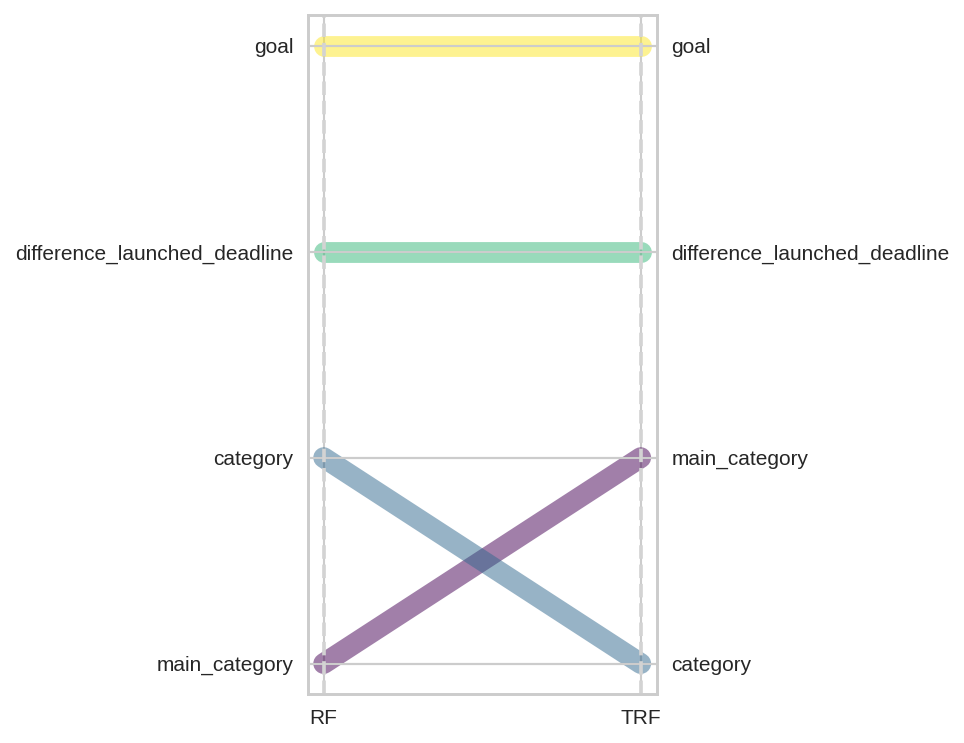

In [151]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

In [ ]:
results_trt

## Reverse Learning Curve

In [ ]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

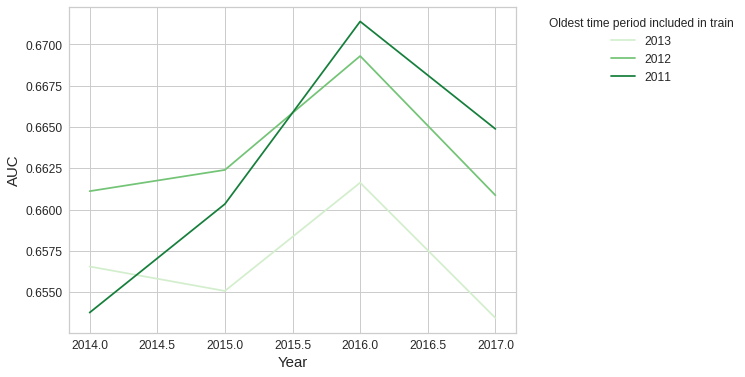

In [147]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

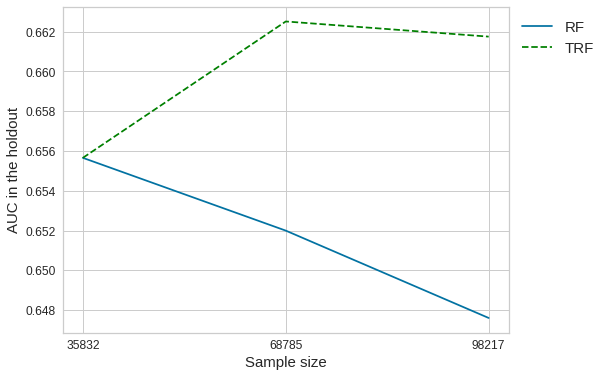

In [148]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

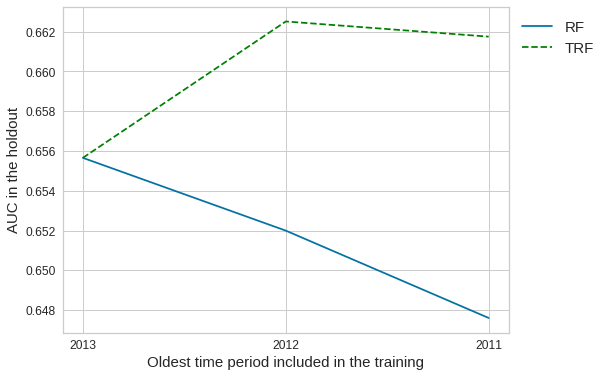

In [149]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

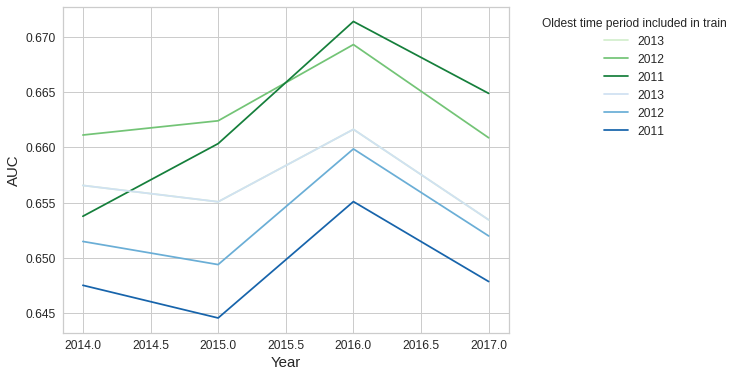

In [144]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

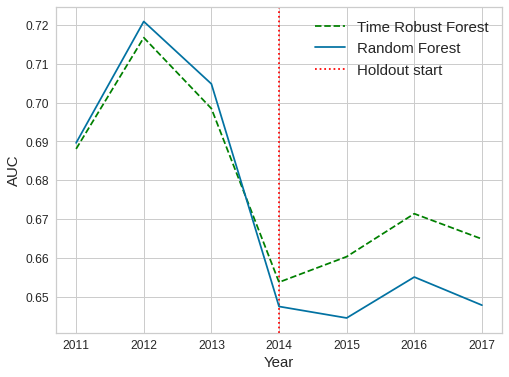

In [145]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

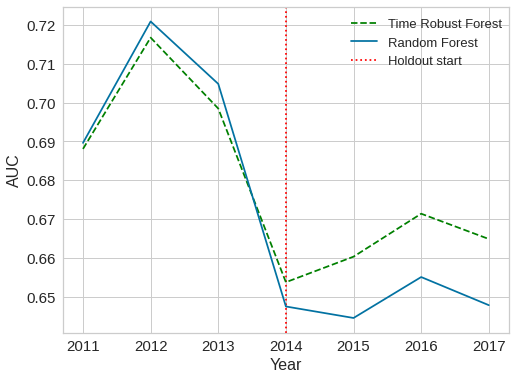

In [146]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, 
           bbox_to_anchor=(0.62, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [ ]:
challenger_model.feature_importance()

In [ ]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

In [ ]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

In [ ]:
selected_features

In [ ]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [131]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7239559450499766
0.7032002263191833
0.6613029214790184


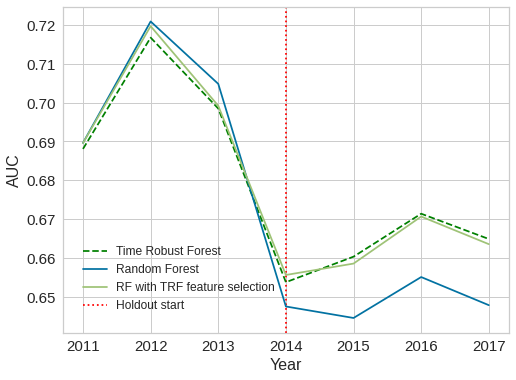

In [143]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="RF with TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(0.50, 0.30))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [ ]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

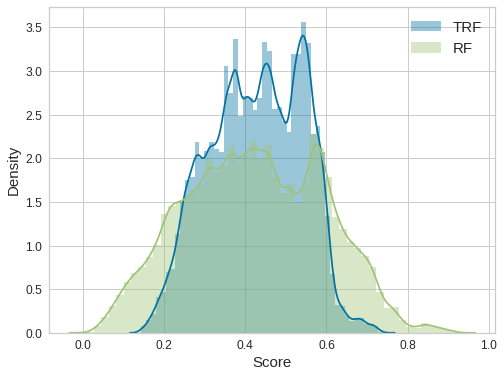

In [130]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction"]])

In [ ]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

In [ ]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

In [ ]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [ ]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

In [ ]:
# pred_test = gam_challenger.predict(X_test[features])
# print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

# pred_test = gam_benchmark.predict(X_test[features])
# print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [ ]:
X_test.describe()

In [ ]:
import matplotlib as mpl 
mpl.rcParams['agg.path.chunksize'] = 10000

In [ ]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    #XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
    #XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

In [ ]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        #try:
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat, fontsize=15)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)

        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

        plt.show()
        plt.clf()
#         except:
#             print("No plot for {}".format(feat))
plt.show()

In [ ]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))

        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [ ]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [ ]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

challenger_params = challenger_opt_param.copy()
challenger_params.pop("min_sample_periods")
for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        min_sample_periods=min_sample_periods,
                                        multi=True,
                                        **challenger_params)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

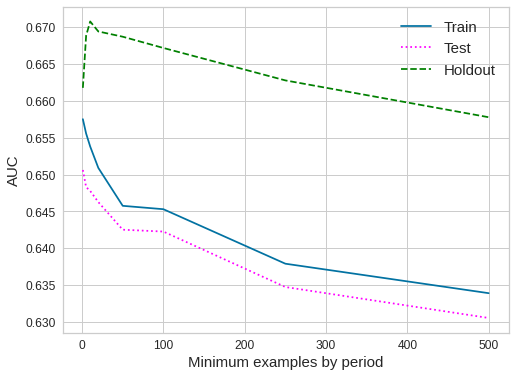

In [129]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

In [ ]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

bench_params = benchmark_opt_param.copy()
bench_params.pop("min_sample_periods")

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       min_sample_periods=training_segments * min_sample_periods,
                                       **bench_params)
    
    
    model.fit(train[features + [DUMMY_TIME_COLUMN]],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

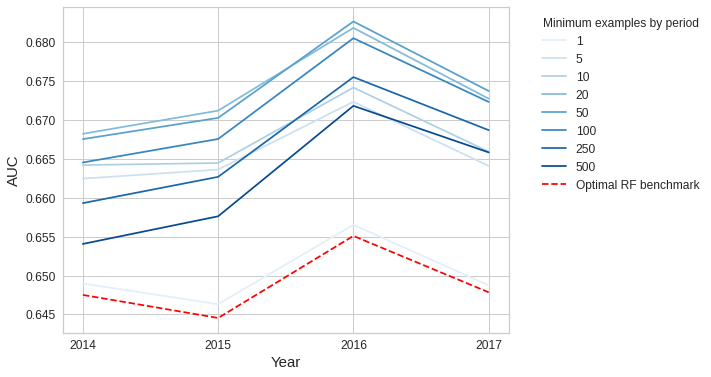

In [125]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

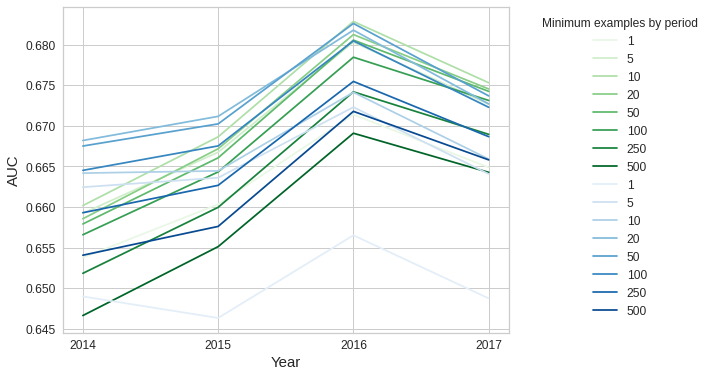

In [126]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

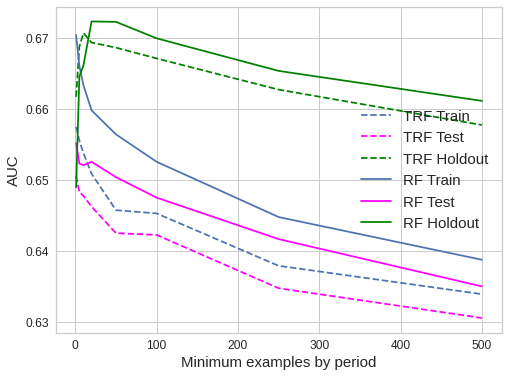

In [127]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

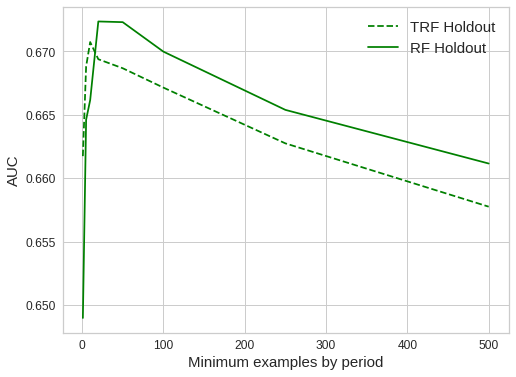

In [128]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [ ]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [ ]:
domain_data = pd.concat([train, test, out_of_time])

In [ ]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [ ]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [ ]:
domain_model = tuned_domain_rf

In [ ]:
domain_model.fit(train_domain[features], train_domain["domain"])

In [ ]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [124]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.8255058023601775

## Other optimization design for the RF

In [ ]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

In [ ]:
posfix = str(last_time_segment_in_train)

In [ ]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
